In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Load the FashionMNIST dataset (split into train and validation sets)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

validationset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=False, num_workers=2)


In [32]:
# Define the InceptionSmall model
class InceptionSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionSmall, self).__init__()
        self.conv1 = ConvModule(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, f_1x1=32, f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64, f_1x1=32, f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80, f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160, f_1x1=112, f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160, f_1x1=96, f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160, f_1x1=80, f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160, f_1x1=48, f_3x3=96)
        self.down2 = DownsampleModule(in_channels=144, f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240, f_1x1=176, f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336, f_1x1=176, f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Train the model using CyclicLR and plot train/validation loss and accuracy
def train_with_cyclic_lr(model, trainloader, validationloader, lr_min, lr_max, step_size, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_min)

    # Cyclical learning rate scheduler
    scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, mode='triangular2')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training loop
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(validationloader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [33]:
# Hyperparameters
lr_min = 1e-4  # Set lr_min from Question 1
lr_max = 1e-2  # Set lr_max from Question 1
step_size = 2000  # Can be adjusted based on the data size
epochs = 10

# Initialize the model and train using cyclic learning rate
model = InceptionSmall()
train_losses, val_losses, train_accuracies, val_accuracies = train_with_cyclic_lr(model, trainloader, validationloader, lr_min, lr_max, step_size, epochs)

# Plot train/validation loss and accuracy curves
epochs_range = np.arange(1, epochs + 1)

Epoch 1, Train Loss: 0.4946, Val Loss: 0.3250, Train Acc: 83.40%, Val Acc: 88.13%
Epoch 2, Train Loss: 0.3003, Val Loss: 0.2770, Train Acc: 89.05%, Val Acc: 89.57%
Epoch 3, Train Loss: 0.2508, Val Loss: 0.2500, Train Acc: 91.02%, Val Acc: 90.74%
Epoch 4, Train Loss: 0.1868, Val Loss: 0.1976, Train Acc: 93.23%, Val Acc: 92.87%
Epoch 5, Train Loss: 0.1339, Val Loss: 0.2105, Train Acc: 95.25%, Val Acc: 92.70%
Epoch 6, Train Loss: 0.1737, Val Loss: 0.2448, Train Acc: 93.64%, Val Acc: 91.14%
Epoch 7, Train Loss: 0.1886, Val Loss: 0.2433, Train Acc: 93.14%, Val Acc: 91.33%
Epoch 8, Train Loss: 0.1402, Val Loss: 0.1943, Train Acc: 94.91%, Val Acc: 93.09%
Epoch 9, Train Loss: 0.0776, Val Loss: 0.2018, Train Acc: 97.28%, Val Acc: 93.53%
Epoch 10, Train Loss: 0.0795, Val Loss: 0.2208, Train Acc: 97.06%, Val Acc: 92.81%


In [25]:
!nvidia-smi

Fri Sep 27 23:05:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |    437MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

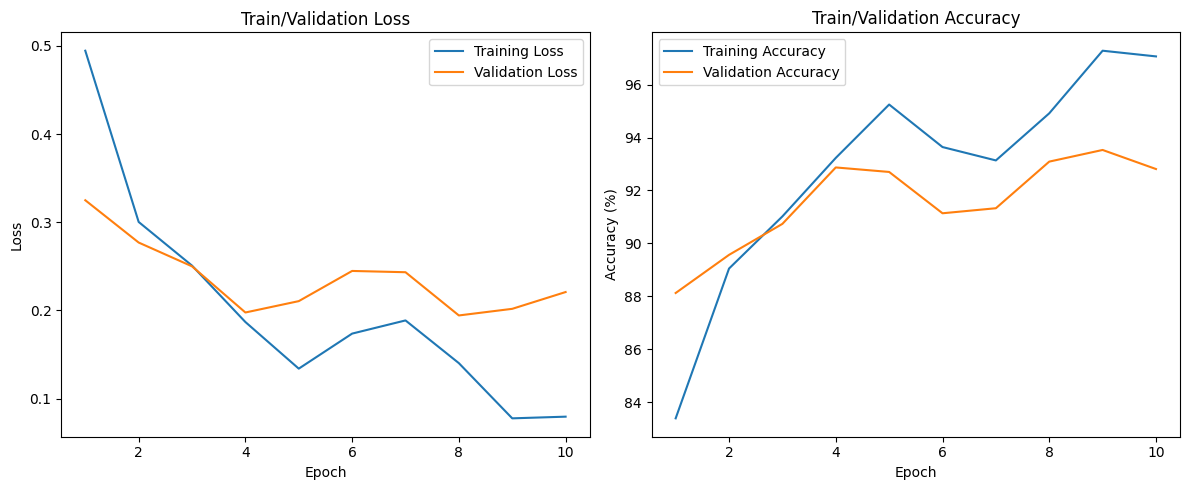

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()